In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [8]:
def print_scores(tag, y_true, y_pred):
    """Helper to print accuracy and F1."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{tag} - accuracy: {acc:.4f}, f1: {f1:.4f}")

def make_pipeline_with_rf(**rf_kwargs):
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **rf_kwargs,
    )
    pipe = Pipeline(
        steps=[
            #("preprocess", preprocess),
            ("model", rf),
        ]
    )
    return pipe

In [9]:
df = pd.read_csv('heart_cleaned.csv')
print(df.head())

target_col = "HeartDisease"

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

for col in categorical_cols:
    df[col] = df[col].astype("category").cat.codes

X = df.drop(columns=[target_col])
y = df[target_col]

print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numeric columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
   Age  Sex  Ch

In [6]:
# Train / test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # binary classification, using stratify to keep the ratio
)

# preprocess = ColumnTransformer(
#     transformers=[
#         ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
#         ("num", "passthrough", numeric_cols),
#     ]
# )


In [11]:
# Decision Tree baseline
print("\n=== Decision Tree baseline (no tuning) ===")
dt = DecisionTreeClassifier(
    random_state=42,  
)
dt_pipe = Pipeline(
    steps=[
        #("preprocess", preprocess),
        ("model", dt),
    ]
)

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)
print_scores("Decision Tree baseline (test)", y_test, y_pred_dt)

# calculate cv：
dt_cv = cross_val_score(
    dt_pipe, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)
print(f"Decision Tree baseline CV F1 mean: {dt_cv.mean():.6f}")


=== Decision Tree baseline (no tuning) ===
Decision Tree baseline (test) - accuracy: 0.7663, f1: 0.7861
Decision Tree baseline CV F1 mean: 0.820067


In [13]:
# GBDT baseline 
print("\n=== Gradient Boosting baseline (no tuning) ===")

from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(
    random_state=42
)

gbdt_pipe = Pipeline(
    steps=[
        #("preprocess", preprocess),
        ("model", gbdt),
    ]
)

# Train and evaluate on test set
gbdt_pipe.fit(X_train, y_train)
y_pred_gbdt = gbdt_pipe.predict(X_test)
print_scores("GBDT baseline (test)", y_test, y_pred_gbdt)

# Cross-validation performance
gbdt_cv = cross_val_score(
    gbdt_pipe, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)
print(f"GBDT baseline CV F1 mean: {gbdt_cv.mean():.6f}")


=== Gradient Boosting baseline (no tuning) ===
GBDT baseline (test) - accuracy: 0.8696, f1: 0.8824
GBDT baseline CV F1 mean: 0.867483


In [12]:
# tuning Step 1: Baseline model
print("\n=== Step 1: Baseline model ===")
baseline_params = {
    "n_estimators": 200,   # start with a bigger one
    # default with other parameters
}
baseline_pipe = make_pipeline_with_rf(**baseline_params)
baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)
print_scores("Baseline", y_test, y_pred_baseline)
cv_baseline = cross_val_score(baseline_pipe, X_train, y_train, cv=5, scoring="f1")
print("Baseline CV F1 mean:", cv_baseline.mean())


=== Step 1: Baseline model ===
Baseline - accuracy: 0.8750, f1: 0.8889
Baseline CV F1 mean: 0.8692105841344364


In [9]:
# tuning Step 2: Tune max_depth & min_samples_leaf
print("\n=== Step 2: Tune max_depth & min_samples_leaf ===")
# start from baseline， max_depth & min_samples_leaf grid search
step2_pipe = baseline_pipe

param_grid_step2 = {
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [1, 2, 4],
}

grid_step2 = GridSearchCV(
    estimator=step2_pipe,
    param_grid=param_grid_step2,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step2.fit(X_train, y_train)

print("Best params (Step 2):", grid_step2.best_params_)
print("Best CV f1 (Step 2):", grid_step2.best_score_)

best_max_depth = grid_step2.best_params_["model__max_depth"]
best_min_samples_leaf = grid_step2.best_params_["model__min_samples_leaf"]


=== Step 2: Tune max_depth & min_samples_leaf ===
Best params (Step 2): {'model__max_depth': 5, 'model__min_samples_leaf': 4}
Best CV f1 (Step 2): 0.876123453643525


In [53]:
# tuning Step 3: Tune n_estimators
print("\n=== Step 3: Tune n_estimators ===")
# based on best step2 parameters, adjust the tree numbers
step3_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
)

param_grid_step3 = {
    "model__n_estimators": [100, 300, 500],  
}

grid_step3 = GridSearchCV(
    estimator=step3_pipe,
    param_grid=param_grid_step3,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step3.fit(X_train, y_train)

print("Best params (Step 3):", grid_step3.best_params_)
print("Best CV f1 (Step 3):", grid_step3.best_score_)

best_n_estimators = grid_step3.best_params_["model__n_estimators"]


=== Step 3: Tune n_estimators ===
Best params (Step 3): {'model__n_estimators': 300}
Best CV f1 (Step 3): 0.8743601145620806


In [54]:
# tuning Step 4: Tune max_features
print("\n=== Step 4: Tune max_features ===")
# based on the latter steps, adjust the max_features
step4_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    n_estimators=best_n_estimators,
)

param_grid_step4 = {
    "model__max_features": ["sqrt", 0.5],  # sqrt classic，0.5 
}

grid_step4 = GridSearchCV(
    estimator=step4_pipe,
    param_grid=param_grid_step4,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step4.fit(X_train, y_train)

print("Best params (Step 4):", grid_step4.best_params_)
print("Best CV f1 (Step 4):", grid_step4.best_score_)

best_max_features = grid_step4.best_params_["model__max_features"]


=== Step 4: Tune max_features ===
Best params (Step 4): {'model__max_features': 'sqrt'}
Best CV f1 (Step 4): 0.8743601145620806


In [55]:
# tuning Step 5: min_samples_split & bootstrap
print("\n=== Step 5: Fine-tune min_samples_split & bootstrap ===")
step5_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    n_estimators=best_n_estimators,
    max_features=best_max_features,
)

param_grid_step5 = {
    "model__min_samples_split": [2, 5, 10],
    "model__bootstrap": [True, False],
}

grid_step5 = GridSearchCV(
    estimator=step5_pipe,
    param_grid=param_grid_step5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step5.fit(X_train, y_train)

print("Best params (Step 5):", grid_step5.best_params_)
print("Best CV f1 (Step 5):", grid_step5.best_score_)

best_min_samples_split = grid_step5.best_params_["model__min_samples_split"]
best_bootstrap = grid_step5.best_params_["model__bootstrap"]


=== Step 5: Fine-tune min_samples_split & bootstrap ===
Best params (Step 5): {'model__bootstrap': True, 'model__min_samples_split': 5}
Best CV f1 (Step 5): 0.8758880425820863


In [56]:
# tuningStep 6: Small joint grid search, around Step 5 best params
print("\n=== Step 6: Joint fine-tuning around Step 5 best params ===")

# constrcut a range centraled with the best parameters
# max_depth 
if best_max_depth is None:
    max_depth_candidates = [None, 10, 15]
else:
    lower = max(3, best_max_depth - 2)
    upper = best_max_depth + 2
    max_depth_candidates = sorted(set([lower, best_max_depth, upper]))

# n_estimators
n_min = max(50, best_n_estimators - 100)
n_max = best_n_estimators + 100
n_estimators_candidates = sorted(set([n_min, best_n_estimators, n_max]))

# min_samples_leaf
leaf_candidates = sorted(set([best_min_samples_leaf,
                                max(1, best_min_samples_leaf - 1)]))

# max_features
if best_max_features == "sqrt":
    max_features_candidates = ["sqrt", 0.5]
else:
    max_features_candidates = [best_max_features, "sqrt"]

# min_samples_split
split_candidates = sorted(set([best_min_samples_split, 2, 5, 10]))

# bootstrap
bootstrap_candidates = [True, False]

print("Joint search candidate space:")
print("  n_estimators:", n_estimators_candidates)
print("  max_depth:", max_depth_candidates)
print("  min_samples_leaf:", leaf_candidates)
print("  max_features:", max_features_candidates)
print("  min_samples_split:", split_candidates)
print("  bootstrap:", bootstrap_candidates)

step6_pipe = make_pipeline_with_rf()

param_grid_step6 = {
    "model__n_estimators": n_estimators_candidates,
    "model__max_depth": max_depth_candidates,
    "model__min_samples_leaf": leaf_candidates,
    "model__max_features": max_features_candidates,
    "model__min_samples_split": split_candidates,
    "model__bootstrap": bootstrap_candidates,
}

grid_step6 = GridSearchCV(
    estimator=step6_pipe,
    param_grid=param_grid_step6,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step6.fit(X_train, y_train)

print("Best params (Step 6 - joint):", grid_step6.best_params_)
print("Best CV f1 (Step 6 - joint):", grid_step6.best_score_)
best_cv_step6 = grid_step6.best_score_

print(f"\nCompare Step5 vs Step6 CV F1:")
print(f"  Step 5 best CV F1: {grid_step5.best_score_:.6f}")
print(f"  Step 6 best CV F1: {best_cv_step6:.6f}")

best_params_step6 = grid_step6.best_params_


=== Step 6: Joint fine-tuning around Step 5 best params ===
Joint search candidate space:
  n_estimators: [200, 300, 400]
  max_depth: [3, 5, 7]
  min_samples_leaf: [1]
  max_features: ['sqrt', 0.5]
  min_samples_split: [2, 5, 10]
  bootstrap: [True, False]
Best params (Step 6 - joint): {'model__bootstrap': False, 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Best CV f1 (Step 6 - joint): 0.8803220647245485

Compare Step5 vs Step6 CV F1:
  Step 5 best CV F1: 0.875888
  Step 6 best CV F1: 0.880322


In [57]:
# Final RF model evaluation (Step 6 best)
print("\n=== Final RF model (Step 6 best) evaluation on test set ===")

final_pipe = make_pipeline_with_rf(
    n_estimators=best_params_step6["model__n_estimators"],
    max_depth=best_params_step6["model__max_depth"],
    min_samples_leaf=best_params_step6["model__min_samples_leaf"],
    max_features=best_params_step6["model__max_features"],
    min_samples_split=best_params_step6["model__min_samples_split"],
    bootstrap=best_params_step6["model__bootstrap"],
)

final_pipe.fit(X_train, y_train)
y_pred_final = final_pipe.predict(X_test)
print_scores("RF Final (Step 6 best, test)", y_test, y_pred_final)
print("\nRF Final (Step 6) classification report:\n")
print(classification_report(y_test, y_pred_final))


=== Final RF model (Step 6 best) evaluation on test set ===
RF Final (Step 6 best, test) - accuracy: 0.8804, f1: 0.8932

RF Final (Step 6) classification report:

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184




Confusion matrix (RF Final):
 [[70 12]
 [10 92]]


<Figure size 640x480 with 0 Axes>

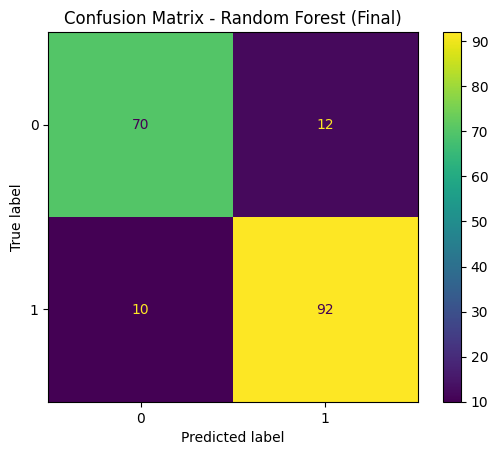


RF Final ROC-AUC: 0.9266


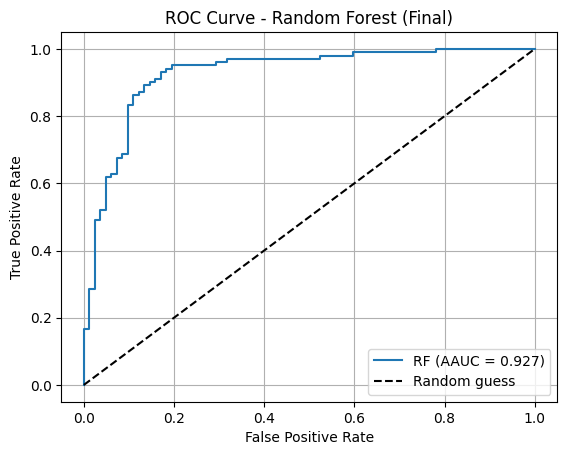


Top 15 feature importances (RF Final):
           feature  importance
10        ST_Slope    0.343759
2    ChestPainType    0.170199
9          Oldpeak    0.109287
8   ExerciseAngina    0.096435
7            MaxHR    0.086538
4      Cholesterol    0.044308
0              Age    0.040436
1              Sex    0.036040
3        RestingBP    0.031648
5        FastingBS    0.029783
6       RestingECG    0.011566


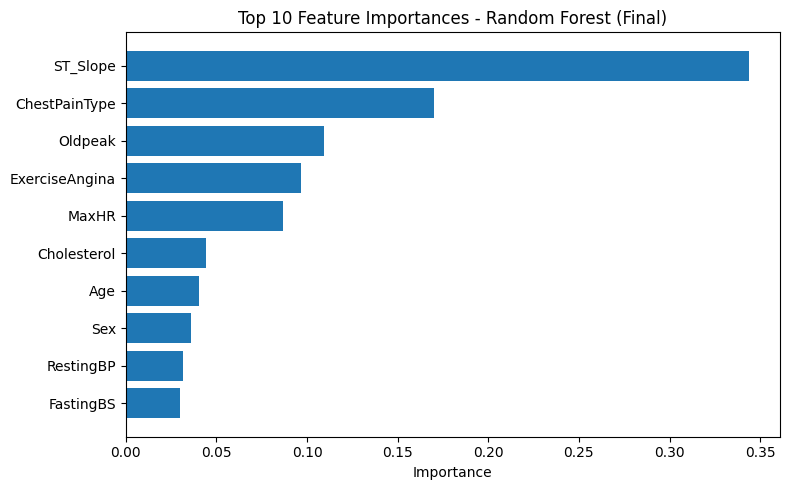

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion matrix (RF Final):\n", cm)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest (Final)")
plt.show()

# ROC curve
y_proba_final = final_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
auc = roc_auc_score(y_test, y_proba_final)
print(f"\nRF Final ROC-AUC: {auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"RF (AAUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Final)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature Importance
rf_final = final_pipe.named_steps["model"]

feature_names = np.array(X_train.columns)

importances = rf_final.feature_importances_

# sorting
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("\nTop 15 feature importances (RF Final):")
print(fi_df.head(15))

# plot
top_k = 10
top_fi = fi_df.head(top_k)

plt.figure(figsize=(8, 5))
plt.barh(top_fi["feature"][::-1], top_fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - Random Forest (Final)")
plt.tight_layout()
plt.show()
